## 基本：
1. 读入数据并进行适当的转换
2. 设置tensorboard
3. 写入tensoboard
4. 使用tensorboad 检查模型架构
5. 创建一个可视化的交互版本
    - 检查训练数据的几种方法
    - 训练过程种如何跟踪模型的性能
    - 训练后如何评估模型效果


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [16]:
# 数据集转换器,组合多种数据转换方式
transform = transforms.Compose([
    transforms.ToTensor(),     # 转为tensor类型
    # 根据输入的均值和标准差对图像进行归一化
    # input = (input - mean) / std
    transforms.Normalize((0.5,), (0.5,))     
])

data_path = r'C:\Users\86132\Desktop\jupyter\data\pytorch_data'

# 加载数据集,并使用组合转化器对其进行转换
trainset = torchvision.datasets.FashionMNIST(
    data_path, download=True, train=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(
    data_path, download=True, train=False, transform=transform)

# 数据加载器
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

# 衣服类别
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [3]:
# 查看图片
def matplotlib_imgshow(image, one_channel=False):
    if one_channel:
        image = image.mean(dim=0)
        
    img = image * 0.5 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
# 线性变换说明：
l = nn.Linear(20, 10)            # 输入特征为20，输特征为10， 
inputs = torch.randn(128, 20)    # 128个样本，特征数为20
l(inputs).size()                  # 变换后输出，样本总量为128，特征数为10

torch.Size([128, 10])

In [5]:
# 定义神将网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 二维卷积：输入通道数，输出通道数，卷积核数
        self.conv1 = nn.Conv2d(1, 6, 5)    # 卷积层
        self.pool = nn.MaxPool2d(2, 2)     # 池化
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 线性变换：输入特征数数，输出特征数数，图片的尺寸
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 样本卷积后，经激活函数后，并池化
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)             # 线性变换样本特征前，调整样本特征的维度
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
# 定义优化器和损失函数
criterion = nn.CrossEntropyLoss()
# 优化器用于优化神经网络的参数，学习率为0.001
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 1.将图片写入tensorboard

In [7]:
# 导入tensorboad并定义
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

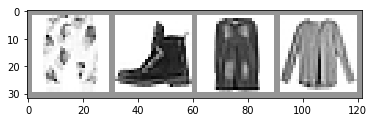

In [17]:
# 写入tensorboard
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 创建图像网格
img_grid = torchvision.utils.make_grid(images)

# 查看图片
matplotlib_imgshow(img_grid, one_channel=True)
# 写入tensorboard
writer.add_image('four images', img_grid)

# 查看tensorboard的方式
# 到 writer 定义的目录下，命令行中启动 : tensorboard --logdir=runs

### 2.添加计算图，进行检查模型

In [9]:
# 添加 计算图，刷新
writer.add_graph(net, images)
writer.close()

### 3.查看高维数据在低维空间的映射

In [10]:
# 添加 projector：高维数据在低维空间中的表示
def select_n_random(data, labels, n=100):
    """ 从数据库中随机选取n 个点及其标签 """
    assert len(data) == len(labels)
    
    # 返回一个从 0 到 n-1 的随机整数数组
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# 获取数据集的数据和标签
images, labels = select_n_random(trainset.data, trainset.targets)
# 依据标签得到对应的类被
class_labels = [classes[lab] for lab in labels]

# 重塑特征
features = images.view(-1, 28 * 28)
writer.add_embedding(
    features,
    metadata=class_labels,
    label_img=images.unsqueeze(1)
)
writer.close()

### 4.tensorboard追踪模型训练

In [14]:
# 辅助函数
def images_to_probs(net, images):
    """ 从训练完的神经网络和一组图片中，得到预测结果和概率值 """
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())   # 删除数组中维度为1的数组
    return preds, [
        F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    """ 绘制预测图、实际类别，预测类别，及概率值等 """
    preds, probs = images_to_probs(net, images)
    
    fig = plt.figure(figsize=(12, 48))
    for idx in range(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imgshow(images[idx], one_channel=True)
        
        ax.set_title('{}, {:.1f}% \n (label: {})'.format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                color=('green' if preds[idx] == labels[idx].item() else 'red')
        )
    return fig

In [15]:
# 训练模型并将结果写入到tensorboard
running_loss = 0.0
for epoch in range(1):   # 多次遍历数据集
    for i, data in enumerate(trainloader, 0):
        # 获取数据和标签
        inputs, labels = data
        optimizer.zero_grad()    # 初始化梯度设为0
        
        outputs = net(inputs)   # 向前传播神经网络
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 999 == 0:
            writer.add_scalar(
                "train loss",
                running_loss / 1000,
                epoch * len(trainloader) + i
            )
        
            # 加载matplotlib 绘制图像
            writer.add_figure(
                'predictions vs actuals',
                plot_classes_preds(net, inputs, labels),
                global_step=epoch * len(trainloader) + i
            )
            running_loss = 0.0

print('训练完成!')

训练完成!


### 5.使用tensorboard评估模型 

In [18]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)